**Train 30 stocks**\
Train: 2012-05-21 --- 2016-09-30\
Val: 2016-10-01 --- 2016-12-31\
Trade: 2017-01-01 --- 2020-12-31

#Prepare


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install stable-baselines3

     |████████████████████████████████| 172 kB 4.2 MB/s 


In [ ]:
!pip install stockstats

In [ ]:
%load_ext tensorboard

In [ ]:
import numpy as np
import pandas as pd
import pathlib
import datetime
import os
import time

In [ ]:
# Orginal data
TRAINING_DATA_FILE = "/content/drive/MyDrive/DATASET/30stocks_original.csv"
# Saving model
now = datetime.datetime.now()
TRAINED_MODEL_DIR = f"/content/drive/MyDrive/SOURCE/trained_models{now}"
os.makedirs(TRAINED_MODEL_DIR)

# Data

In [ ]:
from stockstats import StockDataFrame as Sdf

In [ ]:
def load_dataset(*, file_name: str) -> pd.DataFrame:
    """
    load csv dataset from path
    :return: (df) pandas dataframe
    """
    _data = pd.read_csv(file_name, index_col=0)
    return _data

def data_split(df,start,end):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df.Date >= start) & (df.Date <= end)]
    data=data.sort_values(['Date','Symbol'],ignore_index=True)
    data.index = data.Date.factorize()[0]
    return data

In [ ]:
def add_technical_indicator(df):
    """
    calcualte technical indicators
    use stockstats package to add technical inidactors
    :param data: (df) pandas dataframe
    :return: (df) pandas dataframe
    """
    stock = Sdf.retype(df.copy())

    unique_ticker = stock.symbol.unique()

    macd = pd.DataFrame()
    rsi = pd.DataFrame()
    cci = pd.DataFrame()
    dx = pd.DataFrame()
    sma = pd.DataFrame()
    blbu = pd.DataFrame()
    blbl = pd.DataFrame()

    for i in range(len(unique_ticker)):
        ## macd
        temp_macd = stock[stock.symbol == unique_ticker[i]]['macd']
        temp_macd = pd.DataFrame(temp_macd)
        macd = macd.append(temp_macd, ignore_index=True)
        ## rsi
        temp_rsi = stock[stock.symbol == unique_ticker[i]]['rsi_14']
        temp_rsi = pd.DataFrame(temp_rsi)
        rsi = rsi.append(temp_rsi, ignore_index=True)
        
        ## cci
        temp_cci = stock[stock.symbol == unique_ticker[i]]['cci_14']
        temp_cci = pd.DataFrame(temp_cci)
        cci = cci.append(temp_cci, ignore_index=True)
        ## adx
        temp_dx = stock[stock.symbol == unique_ticker[i]]['dx_14']
        temp_dx = pd.DataFrame(temp_dx)
        dx = dx.append(temp_dx, ignore_index=True)
        
        ## sma
        temp_sma = stock[stock.symbol == unique_ticker[i]]['close_10_sma']
        temp_sma = pd.DataFrame(temp_sma)
        sma = sma.append(temp_sma, ignore_index=True)
      
        ## boll up
        temp_blbu = stock[stock.symbol == unique_ticker[i]]['boll_ub']
        temp_blbu = pd.DataFrame(temp_blbu)
        blbu = blbu.append(temp_blbu, ignore_index=True)
        ## boll low
        temp_blbl = stock[stock.symbol == unique_ticker[i]]['boll_lb']
        temp_blbl = pd.DataFrame(temp_blbl)
        blbl = blbl.append(temp_blbl, ignore_index=True)
        

    df['macd'] = macd
    df['rsi'] = rsi
    df['cci'] = cci
    df['adx'] = dx
    df['sma'] = sma
    df['boll_ub'] = blbu
    df['boll_lb'] = blbl

    return df

In [ ]:
def preprocess_data():
    """data preprocessing pipeline"""

    df = load_dataset(file_name=TRAINING_DATA_FILE)
    # get data after 2012/05/21
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[df.Date>="2012-05-21"]
    # add technical indicators using stockstats
    df_final=add_technical_indicator(df)
    # fill the missing values at the beginning and ending
    df_final.fillna(method='bfill',inplace=True)
    df_final.fillna(method='ffill',inplace=True)
    return df_final

In [ ]:
def calculate_turbulence(data):
    """calculate turbulence index based on data vn"""
    # can add other market assets
    df = data.copy()
    df_price_pivot = df.pivot(index='Date', columns='Symbol', values='adjust')
    # use return to calculate turbulence
    df_price_pivot = df_price_pivot.pct_change()
    unique_date = df.Date.unique()
    # start after a year
    start = 250
    turbulence_index = [0]*start
    #turbulence_index = [0]
    count = 0
    for i in range(start,len(unique_date)):
        current_price = df_price_pivot[df_price_pivot.index == unique_date[i]]
        hist_price = df_price_pivot[[n in unique_date[0:i] for n in df_price_pivot.index ]]
        # Drop tickers which has number missing values more than the "oldest" ticker
        filtered_hist_price = hist_price.iloc[hist_price.isna().sum().min():].dropna(axis=1)
        cov_temp = filtered_hist_price.cov()
        current_temp = current_price[[x for x in filtered_hist_price]] - np.mean(filtered_hist_price, axis=0)
        temp = current_temp.values.dot(np.linalg.pinv(cov_temp)).dot(current_temp.values.T)
        if temp>0:
            count+=1
            if count>2:
                turbulence_temp = temp[0][0]
            else:
                #avoid large outlier because of the calculation just begins
                turbulence_temp=0
        else:
            turbulence_temp=0
        turbulence_index.append(turbulence_temp)
    
    
    turbulence_index = pd.DataFrame({'Date':df_price_pivot.index,
                                     'turbulence':turbulence_index})
    return turbulence_index

def add_turbulence(data):
    """
    add turbulence index from a precalculated dataframe
    :param data: (df) pandas dataframe
    :return: (df) pandas dataframe
    """
    df = data.copy()
    turbulence_index = calculate_turbulence(df)
    df = df.merge(turbulence_index, on='Date')
    df = df.sort_values(['Date','Symbol']).reset_index(drop=True)
    return df


# Custom Environment

In [ ]:
import gym
from gym.utils import seeding
from gym import spaces
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

## Trading environment

In [ ]:
#Trading Environment

# shares normalization factor
# 100 shares per trade
HMAX_NORMALIZE = 100
# initial amount of money we have in our account
INITIAL_ACCOUNT_BALANCE = 1000000
# total number of stocks in our portfolio
STOCK_DIM = 30
# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001

REWARD_SCALING = 1e-4

class StockEnvTrade(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0,turbulence_threshold = None
                 ,initial=True, previous_state=[], model_name='', iteration=''):
        #super(StockEnvTrade, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.df = df
        self.initial = initial
        self.previous_state = previous_state
        # action_space normalization and shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 271: [Current Balance]+[prices 1-30]+[owned shares 1-30] 
        # +[macd 1-30] + [rsi 1-30] + [cci 1-30] + [adx 1-30] + [sma 1-29]
        # +[boll_ub 1-30] + [boll_lb 1-30]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (271,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.adjust.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist() + \
                      self.data.cci.values.tolist() + \
                      self.data.adx.values.tolist() + \
                      self.data.sma.values.tolist() + \
                      self.data.boll_ub.values.tolist() + \
                      self.data.boll_lb.values.tolist()
        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        # memorize all the total balance change
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        #self.reset()
        self._seed()
        self.model_name=model_name        
        self.iteration=iteration
        

    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.turbulence<self.turbulence_threshold:
            if self.state[index+STOCK_DIM+1] > 0:
                #update balance
                sell_num_shares = min(abs(action),self.state[index+STOCK_DIM+1])
                sell_amount = self.state[index+1] * sell_num_shares * (1- TRANSACTION_FEE_PERCENT)
                self.state[0] += sell_amount
                
                self.state[index+STOCK_DIM+1] -= sell_num_shares
                self.cost +=self.state[index+1] * sell_num_shares * \
                 TRANSACTION_FEE_PERCENT
                self.trades+=1
            else:
                sell_num_shares = 0
        else:
            # if turbulence goes over threshold, just clear out all positions 
            if self.state[index+STOCK_DIM+1] > 0:
                #update balance
                sell_num_shares = self.state[index+STOCK_DIM+1]
                sell_amount = self.state[index+1] * sell_num_shares * (1- TRANSACTION_FEE_PERCENT)
                self.state[0] += sell_amount
                self.state[index+STOCK_DIM+1] =0
                self.cost += self.state[index+1]*self.state[index+STOCK_DIM+1]* \
                              TRANSACTION_FEE_PERCENT
                self.trades+=1
            else:
                sell_num_shares = 0

        return sell_num_shares
    
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        if self.turbulence< self.turbulence_threshold:
            available_amount = self.state[0] // self.state[index+1]
            #print('available_amount:{}'.format(available_amount))
            
            #update balance
            buy_num_shares = min(available_amount, action)
            buy_amount = self.state[index+1] * buy_num_shares * (1+ TRANSACTION_FEE_PERCENT)
            self.state[0] -= buy_amount
            
            self.state[index+STOCK_DIM+1] += buy_num_shares
            
            self.cost += self.state[index+1] * buy_num_shares * \
                              TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            # if turbulence goes over threshold, just stop buying
            buy_num_shares = 0
            pass

        return buy_num_shares
        
    def step(self, actions):
        #print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        #print(actions)

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('/content/drive/MyDrive/SOURCE/results/account_value_trade_{}_{}.png'.format(self.model_name, self.iteration))
            plt.close()
            df_total_value = pd.DataFrame(self.asset_memory)
            #df_total_value.to_csv('/content/drive/MyDrive/DRL_DataVN_sb3/results/account_value_trade_{}_{}.csv'.format(self.model_name, self.iteration))
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            df_total_value.columns = ['account_value']
            df_total_value['Date'] = self.date_memory
            df_total_value['daily_return']=df_total_value['account_value'].pct_change(1)
            sharpe = (4**0.5)*df_total_value['daily_return'].mean()/ \
                  df_total_value['daily_return'].std()
            print("previous_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(end_total_asset))
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))- self.asset_memory[0] ))
            print("total_cost: ", self.cost)
            print("total_trades: ", self.trades)
            print("Sharpe: ",sharpe)
            df_total_value.to_csv('/content/drive/MyDrive/SOURCE/results/account_value_trade_{}_{}.csv'.format(self.model_name, self.iteration))
            
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ['account_rewards']
            df_rewards['Date'] = self.date_memory[:-1]
            df_rewards.to_csv('/content/drive/MyDrive/SOURCE/results/account_rewards_trade_{}_{}.csv'.format(self.model_name, self.iteration))
            
            df_actions = self.save_action_memory()
            df_actions.to_csv('/content/drive/MyDrive/SOURCE/results/actions_{}_{}.csv'.format(self.model_name, self.iteration))
            
            return self.state, self.reward, self.terminal,{}

        else:
            # print(np.array(self.state[1:29]))

            actions = actions * HMAX_NORMALIZE
            actions = (actions.astype(int))
            if self.turbulence>=self.turbulence_threshold:
                actions=np.array([-HMAX_NORMALIZE]*STOCK_DIM)
                
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                #print('take sell action: {}'.format(actions[index]))
                actions[index] = self._sell_stock(index, actions[index]) * (-1)

            for index in buy_index:
                #print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])
            
            self.actions_memory.append(actions)

            self.day += 1
            self.data = self.df.loc[self.day,:]         
            self.turbulence = self.data['turbulence'].values[0]
            # print(self.turbulence)
            #load next state
            self.state =  [self.state[0]] + \
                    self.data.adjust.values.tolist() + \
                    list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) + \
                    self.data.macd.values.tolist() + \
                    self.data.rsi.values.tolist() + \
                    self.data.cci.values.tolist() + \
                    self.data.adx.values.tolist() + \
                    self.data.sma.values.tolist() + \
                    self.data.boll_ub.values.tolist() + \
                    self.data.boll_lb.values.tolist()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.asset_memory.append(end_total_asset)
            #print("end_total_asset:{}".format(end_total_asset))
            self.date_memory.append(self._get_date())
            
            self.reward = end_total_asset - begin_total_asset            
            # print("step_reward:{}".format(self.reward))
            self.rewards_memory.append(self.reward)
            
            self.reward = self.reward*REWARD_SCALING


        return self.state, self.reward, self.terminal, {}

    def reset(self):  
        if self.initial:
            self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
            self.day = 0
            self.data = self.df.loc[self.day,:]
            self.turbulence = 0
            self.cost = 0
            self.trades = 0
            self.terminal = False 
            #self.iteration=self.iteration
            self.rewards_memory = []
            self.actions_memory = []
            self.date_memory = [self._get_date()]
            #initiate state
            self.state = [INITIAL_ACCOUNT_BALANCE] + \
                          self.data.adjust.values.tolist() + \
                          [0]*STOCK_DIM + \
                          self.data.macd.values.tolist() + \
                          self.data.rsi.values.tolist()  + \
                          self.data.cci.values.tolist() + \
                          self.data.adx.values.tolist() + \
                          self.data.sma.values.tolist() + \
                          self.data.boll_ub.values.tolist() + \
                          self.data.boll_lb.values.tolist()
        else:
            previous_total_asset = self.previous_state[0]+ \
            sum(np.array(self.previous_state[1:(STOCK_DIM+1)])*np.array(self.previous_state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.asset_memory = [previous_total_asset]
            #self.asset_memory = [self.previous_state[0]]
            self.day = 0
            self.data = self.df.loc[self.day,:]
            self.turbulence = 0
            self.cost = 0
            self.trades = 0
            self.terminal = False 
            #self.iteration=iteration
            self.rewards_memory = []
            self.actions_memory = []
            self.date_memory = [self._get_date()]
            
            #initiate state
            self.state = [ self.previous_state[0]] + \
                          self.data.adjust.values.tolist() + \
                          self.previous_state[(STOCK_DIM+1):(STOCK_DIM*2+1)]+ \
                          self.data.macd.values.tolist() + \
                          self.data.rsi.values.tolist()  + \
                          self.data.cci.values.tolist() + \
                          self.data.adx.values.tolist() + \
                          self.data.sma.values.tolist() + \
                          self.data.boll_ub.values.tolist() + \
                          self.data.boll_lb.values.tolist()            
        return self.state
    
    def render(self, mode='human',close=False):
        return self.state
    
    def _get_date(self):
      if len(self.df.Symbol.unique())>1:
        date = self.data.Date.unique()[0]
      else:
        date = self.data.Date
      return date
    
    def save_action_memory(self):
      if len(self.df.Symbol.unique())>1:
        date_list = self.date_memory[:-1]
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['Date']

        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.Symbol.values
        df_actions.index = df_date.Date
      else:
        date_list = self.date_memory[:-1]
        action_list = self.actions_memory
        df_actions =pd.DataFrame({'Date': date_list, 'Actions': action_list})
      return df_actions
    

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


## Train Environment

In [ ]:
#Train Environment

# shares normalization factor
# 100 shares per trade
HMAX_NORMALIZE = 100
# initial amount of money we have in our account
INITIAL_ACCOUNT_BALANCE = 1000000
# total number of stocks in our portfolio
STOCK_DIM = 30
# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001
REWARD_SCALING = 1e-4


class StockEnvTrain(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0):
        #super(StockEnvTrain, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.df = df

        # action_space normalization and shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 271: [Current Balance]+[prices 1-30]+[owned shares 1-30] 
        # +[macd 1-30]+ [rsi 1-30] + [cci 1-30] + [adx 1-30] + [sma 1-29]
        # + [boll_ub 1-30] + [boll_lb 1-30]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (271,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False             
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.adjust.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist() + \
                      self.data.cci.values.tolist() + \
                      self.data.adx.values.tolist() + \
                      self.data.sma.values.tolist() + \
                      self.data.boll_ub.values.tolist() + \
                      self.data.boll_lb.values.tolist()
        # initialize reward
        self.reward = 0
        self.cost = 0
        # memorize all the total balance change
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []
        self.trades = 0
        #self.reset()
        self._seed()

    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.state[index+STOCK_DIM+1] > 0:
            #update balance
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             (1- TRANSACTION_FEE_PERCENT)

            self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            pass

    
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        available_amount = self.state[0] // self.state[index+1]
        # print('available_amount:{}'.format(available_amount))

        #update balance
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ TRANSACTION_FEE_PERCENT)

        self.state[index+STOCK_DIM+1] += min(available_amount, action)

        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          TRANSACTION_FEE_PERCENT
        self.trades+=1
        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        #print(actions)

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('/content/drive/MyDrive/SOURCE/results/account_value_train.png')
            plt.close()
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            
            #print("end_total_asset:{}".format(end_total_asset))
            df_total_value = pd.DataFrame(self.asset_memory)
            #df_total_value.to_csv('/content/drive/MyDrive/SOURCE/results/account_value_train.csv')
            #print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):61]))- INITIAL_ACCOUNT_BALANCE ))
            #print("total_cost: ", self.cost)
            #print("total_trades: ", self.trades)
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            #print(df_total_value)
            sharpe = (252**0.5)*df_total_value['daily_return'].mean()/df_total_value['daily_return'].std()
            df_total_value.to_csv('/content/drive/MyDrive/SOURCE/results/account_value_train.csv')
            #print("Sharpe: ",sharpe)
            #print("=================================")
            df_rewards = pd.DataFrame(self.rewards_memory)
            #df_rewards.to_csv('results/account_rewards_train.csv')
            
            
            return self.state, self.reward, self.terminal,{}

        else:
            
            actions = actions * HMAX_NORMALIZE
            #actions = (actions.astype(int))
            
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                #print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                #print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]         
            #load next state
            self.state =  [self.state[0]] + \
                    self.data.adjust.values.tolist() + \
                    list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) + \
                    self.data.macd.values.tolist() + \
                    self.data.rsi.values.tolist() + \
                    self.data.cci.values.tolist() + \
                    self.data.adx.values.tolist() + \
                    self.data.sma.values.tolist() + \
                    self.data.boll_ub.values.tolist() + \
                    self.data.boll_lb.values.tolist()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.asset_memory.append(end_total_asset)
            #print("end_total_asset:{}".format(end_total_asset))
            
            self.reward = end_total_asset - begin_total_asset            
            # print("step_reward:{}".format(self.reward))
            self.rewards_memory.append(self.reward)
            
            self.reward = self.reward*REWARD_SCALING



        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.adjust.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist() + \
                      self.data.cci.values.tolist() + \
                      self.data.adx.values.tolist() + \
                      self.data.sma.values.tolist() + \
                      self.data.boll_ub.values.tolist() + \
                      self.data.boll_lb.values.tolist() 
        return self.state
    
    def render(self, mode='human'):
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

## Validation Environment

In [ ]:
#Validation Environment

# shares normalization factor
# 100 shares per trade
HMAX_NORMALIZE = 100
# initial amount of money we have in our account
INITIAL_ACCOUNT_BALANCE = 1000000
# total number of stocks in our portfolio
STOCK_DIM = 30
# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001

# turbulence index: 90-150 reasonable threshold
REWARD_SCALING = 1e-4

class StockEnvValidation(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, day = 0, turbulence_threshold=None, iteration=''):
        #super(StockEnvValidation, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.df = df
        # action_space normalization and shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 271: [Current Balance]+[prices 1-30]+[owned shares 1-30] 
        # +[macd 1-30]+ [rsi 1-30] + [cci 1-30] + [adx 1-30] + [sma 1-30]
        # + [boll_ub 1-30] + [boll_lb 1-30]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (271,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.adjust.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist() + \
                      self.data.cci.values.tolist() + \
                      self.data.adx.values.tolist() + \
                      self.data.sma.values.tolist() + \
                      self.data.boll_ub.values.tolist() + \
                      self.data.boll_lb.values.tolist()
        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        # memorize all the total balance change
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []
        #self.reset()
        self._seed()
        
        self.iteration=iteration


    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.turbulence<self.turbulence_threshold:
            if self.state[index+STOCK_DIM+1] > 0:
                #update balance
                self.state[0] += \
                self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
                 (1- TRANSACTION_FEE_PERCENT)
                
                self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
                self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
                 TRANSACTION_FEE_PERCENT
                self.trades+=1
            else:
                pass
        else:
            # if turbulence goes over threshold, just clear out all positions 
            if self.state[index+STOCK_DIM+1] > 0:
                #update balance
                self.state[0] += self.state[index+1]*self.state[index+STOCK_DIM+1]* \
                              (1- TRANSACTION_FEE_PERCENT)
                self.state[index+STOCK_DIM+1] =0
                self.cost += self.state[index+1]*self.state[index+STOCK_DIM+1]* \
                              TRANSACTION_FEE_PERCENT
                self.trades+=1
            else:
                pass
    
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        if self.turbulence< self.turbulence_threshold:
            available_amount = self.state[0] // self.state[index+1]
            # print('available_amount:{}'.format(available_amount))
            
            #update balance
            self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                              (1+ TRANSACTION_FEE_PERCENT)

            self.state[index+STOCK_DIM+1] += min(available_amount, action)
            
            self.cost+=self.state[index+1]*min(available_amount, action)* \
                              TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            # if turbulence goes over threshold, just stop buying
            pass
        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('/content/drive/MyDrive/SOURCE/results/account_value_validation_{}.png'.format(self.iteration))
            plt.close()
            df_total_value = pd.DataFrame(self.asset_memory)
            #df_total_value.to_csv('/content/drive/MyDrive/SOURCE/results/account_value_validation_{}.csv'.format(self.iteration))
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            #print("previous_total_asset:{}".format(self.asset_memory[0]))           
            #print("end_total_asset:{}".format(end_total_asset))
            #print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):61]))- self.asset_memory[0] ))
            #print("total_cost: ", self.cost)
            #print("total trades: ", self.trades)

            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            sharpe = (4**0.5)*df_total_value['daily_return'].mean()/ \
                  df_total_value['daily_return'].std()
            #print("Sharpe: ",sharpe)
            df_total_value.to_csv('/content/drive/MyDrive/SOURCE/results/account_value_validation_{}.csv'.format(self.iteration))
            
            #df_rewards = pd.DataFrame(self.rewards_memory)
            #df_rewards.to_csv('results/account_rewards_trade_{}.csv'.format(self.iteration))
            
            
            return self.state, self.reward, self.terminal,{}

        else:

            actions = actions * HMAX_NORMALIZE
            #actions = (actions.astype(int))
            if self.turbulence>=self.turbulence_threshold:
                actions=np.array([-HMAX_NORMALIZE]*STOCK_DIM)
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]         
            self.turbulence = self.data['turbulence'].values[0]
            #print(self.turbulence)
            #load next state
            self.state =  [self.state[0]] + \
                    self.data.adjust.values.tolist() + \
                    list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) + \
                    self.data.macd.values.tolist() + \
                    self.data.rsi.values.tolist() + \
                    self.data.cci.values.tolist() + \
                    self.data.adx.values.tolist() + \
                    self.data.sma.values.tolist() + \
                    self.data.boll_ub.values.tolist() + \
                    self.data.boll_lb.values.tolist()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.asset_memory.append(end_total_asset)
            #print("end_total_asset:{}".format(end_total_asset))
            
            self.reward = end_total_asset - begin_total_asset            
            # print("step_reward:{}".format(self.reward))
            self.rewards_memory.append(self.reward)
            
            self.reward = self.reward*REWARD_SCALING

        return self.state, self.reward, self.terminal, {}

    def reset(self):  
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        #self.iteration=self.iteration
        self.rewards_memory = []
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.adjust.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist()  + \
                      self.data.cci.values.tolist() + \
                      self.data.adx.values.tolist() + \
                      self.data.sma.values.tolist() + \
                      self.data.boll_ub.values.tolist() + \
                      self.data.boll_lb.values.tolist()
            
        return self.state
    
    def render(self, mode='human',close=False):
        return self.state
    

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

# Model

In [ ]:
from stable_baselines3 import SAC
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3 import DDPG
from stable_baselines3 import TD3

from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv

In [ ]:
def train_A2C(env_train, model_name, timesteps):
    """A2C model"""
    
    start = time.time()
    model = A2C('MlpPolicy', env_train, ent_coef=0.01)
    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"{TRAINED_MODEL_DIR}/{model_name}")
    print('Training time (A2C): ', (end - start) / 60, ' minutes')
    return model

In [ ]:
def train_PPO(env_train, model_name, timesteps):
    """PPO model"""

    start = time.time()
    model = PPO('MlpPolicy', env_train, ent_coef=0.01)
    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"{TRAINED_MODEL_DIR}/{model_name}")
    print('Training time (PPO): ', (end - start) / 60, ' minutes')
    return model

In [ ]:
def train_DDPG(env_train, model_name, timesteps):
    """DDPG model"""

    # add the noise objects for DDPG
    n_actions = env_train.action_space.shape[-1]
    param_noise = None
    action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

    start = time.time()
    model = DDPG('MlpPolicy', env_train, action_noise=action_noise)
    model.learn(total_timesteps=timesteps)
    end = time.time()
   
    model.save(f"{TRAINED_MODEL_DIR}/{model_name}")
    print('Training time (DDPG): ', (end-start)/60,' minutes')
    return model

In [ ]:
def train_SAC(env_train, model_name, timesteps):
    """SAC model"""
    
    start = time.time()
    model = SAC('MlpPolicy', env_train, batch_size=128, ent_coef='auto_0.1')
    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"{TRAINED_MODEL_DIR}/{model_name}")
    print('Training time (SAC): ', (end - start) / 60, ' minutes')
    return model

In [ ]:
def DRL_prediction(df,
                   model,
                   name,
                   last_state,
                   iter_num,
                   unique_trade_date,
                   rebalance_window,
                   turbulence_threshold,
                   initial):
    ### make a prediction based on trained model###

    ## trading env
    trade_data = data_split(df, start=unique_trade_date[iter_num - rebalance_window], end=unique_trade_date[iter_num])
    env_trade = DummyVecEnv([lambda: StockEnvTrade(trade_data,
                                                   turbulence_threshold=turbulence_threshold,
                                                   initial=initial,
                                                   previous_state=last_state,
                                                   model_name=name,
                                                   iteration=iter_num)])
    obs_trade = env_trade.reset()

    for i in range(len(trade_data.index.unique())):
        action, _states = model.predict(obs_trade)
        obs_trade, rewards, dones, info = env_trade.step(action)
        if i == (len(trade_data.index.unique()) - 2):
            # print(env_test.render())
            last_state = env_trade.render()

    df_last_state = pd.DataFrame({'last_state': last_state})
    df_last_state.to_csv('/content/drive/MyDrive/SOURCE/results/last_state_{}_{}.csv'.format(name, i), index=False)
    return last_state

In [ ]:
def DRL_validation(model, test_data, test_env, test_obs) -> None:
    ###validation process###
    for i in range(len(test_data.index.unique())):
        action, _states = model.predict(test_obs)
        test_obs, rewards, dones, info = test_env.step(action)


In [ ]:
def get_validation_sharpe(iteration):
    ###Calculate Sharpe ratio based on validation results###
    df_total_value = pd.read_csv('/content/drive/MyDrive/SOURCE/results/account_value_validation_{}.csv'.format(iteration), index_col=0)
    #df_total_value.columns = ['account_value_train']
    #df_total_value['daily_return'] = df_total_value.pct_change(1)
    sharpe = (4 ** 0.5) * df_total_value['daily_return'].mean() / \
             df_total_value['daily_return'].std()
    return sharpe

#Convergence


In [ ]:
preprocessed_path = "/content/drive/MyDrive/DATASET/Our_Dataset/30stocks_done.csv"
data = pd.read_csv(preprocessed_path, index_col=0)
train = data_split(data, start="2012-05-21", end="2016-10-01")
env_train = DummyVecEnv([lambda: StockEnvTrain(train)])

In [ ]:
model = A2C('MlpPolicy', env_train, ent_coef=0.01, tensorboard_log="./a2c_tensorboard/")
model.learn(total_timesteps=100000)

In [ ]:
%tensorboard --logdir ./a2c_tensorboard/

In [ ]:
model1 = PPO('MlpPolicy', env_train, ent_coef=0.01, tensorboard_log="./ppo_tensorboard/")
model1.learn(total_timesteps=100000)
#n_steps=2048, learning_rate=0.00025, ent_coef=0.01, batch_size=128,

In [ ]:
%tensorboard --logdir ./ppo_tensorboard/

In [ ]:
n_actions = env_train.action_space.shape[-1]
#param_noise = None
action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

model2 = DDPG('MlpPolicy', env_train, action_noise=action_noise, tensorboard_log="./ddpg_tensorboard/")
model2.learn(total_timesteps=100000)
#buffer_size=50000, learning_rate=0.000005, batch_size=128,

In [ ]:
%tensorboard --logdir ./ddpg_tensorboard/

In [ ]:
model = SAC('MlpPolicy', env_train, ent_coef='auto_0.1', batch_size=128, tensorboard_log="./sac_tensorboard/")
model.learn(total_timesteps=100000)

In [ ]:
%tensorboard --logdir ./sac_tensorboard/

# Run strategy

In [ ]:
def run_ensemble_strategy(df, unique_trade_date, rebalance_window, validation_window) -> None:
    """Ensemble Strategy that combines PPO, A2C and DDPG"""
    print("============Start Ensemble Strategy============")
    # for ensemble model, it's necessary to feed the last state
    # of the previous model to the current model as the initial state
    last_state_ensemble = []

    ppo_sharpe_list = []
    #ddpg_sharpe_list = []
    a2c_sharpe_list = []
    sac_sharpe_list = []

    model_use = []
    validation_start_date_list = []
    validation_end_date_list = []
    iteration_list = []

    # based on the analysis of the in-sample data
    insample_turbulence = df[(df.Date<"2016-10-01") & (df.Date>="2012-05-21")]
    insample_turbulence = insample_turbulence.drop_duplicates(subset=['Date'])
    #insample_turbulence_threshold = np.quantile(insample_turbulence.turbulence.values, .90)
    #print("Insample turbulence threshold: ", insample_turbulence_threshold)

    start = time.time()
    for i in range(rebalance_window + validation_window, len(unique_trade_date), rebalance_window):
        print("============================================")
        validation_start_date = unique_trade_date[i - rebalance_window - validation_window]
        validation_end_date = unique_trade_date[i - rebalance_window]

        validation_start_date_list.append(validation_start_date)
        validation_end_date_list.append(validation_end_date)
        iteration_list.append(i)
        ## initial state is empty
        if i - rebalance_window - validation_window == 0:
            # inital state
            initial = True
        else:
            # previous state
            initial = False
        '''
        # Tuning trubulence index based on historical data
        # Turbulence lookback window is one quarter
        end_date_index = df.index[df["Date"] == unique_trade_date[i - rebalance_window - validation_window]].to_list()[-1]
        start_date_index = end_date_index - validation_window*30 + 1  # 30 tickers
        #start_date_index =df.index[df["Date"] == unique_trade_date[i - rebalance_window - validation_window]].to_list()[-1]
        #end_date_index = start_date_index + rebalance_window*30 + 1

        historical_turbulence = df.iloc[start_date_index:(end_date_index + 1), :]
        #historical_turbulence = df[(df.Date<unique_trade_date[i - rebalance_window - validation_window]) & (df.Date>=(unique_trade_date[i - rebalance_window - validation_window - 63]))]


        # historical_turbulence = historical_turbulence.drop_duplicates(subset=['Date'])
        #print("Historical_turbulence: ", historical_turbulence)
        #historical_turbulence.to_csv("/content/drive/MyDrive/DRL_DataVN_sb3/test_date/historical_tur_{}.csv".format(i))       

        # historical_turbulence_mean = np.mean(historical_turbulence.turbulence.values)
        # print("Historical turbulence mean: ", historical_turbulence_mean)
        # print("Insample turbulence threshold: ", insample_turbulence_threshold)
        
        if historical_turbulence_mean > insample_turbulence_threshold:
            # if the mean of the historical data is greater than the 90% quantile of insample turbulence data
            # then we assume that the current market is volatile,
            # therefore we set the 90% quantile of insample turbulence data as the turbulence threshold
            # meaning the current turbulence can't exceed the 90% quantile of insample turbulence data
            turbulence_threshold = np.quantile(insample_turbulence.turbulence.values, 1)
        else:
            # if the mean of the historical data is less than the 90% quantile of insample turbulence data
            # then we tune up the turbulence_threshold, meaning we lower the risk
            turbulence_threshold = np.quantile(insample_turbulence.turbulence.values, 0.99)
        '''
        turbulence_threshold = np.quantile(insample_turbulence.turbulence.values, 0.999)
        print("Turbulence_threshold: ", turbulence_threshold)
        print("Value of i = ", i)
        
        ############## Environment Setup starts ##############
        ## training env
        train = data_split(df, start="2012-05-21", end=unique_trade_date[i - rebalance_window - validation_window])
        env_train = DummyVecEnv([lambda: StockEnvTrain(train)])

        ## validation env
        validation = data_split(df, start=unique_trade_date[i - rebalance_window - validation_window],
                                end=unique_trade_date[i - rebalance_window])
        env_val = DummyVecEnv([lambda: StockEnvValidation(validation,
                                                          turbulence_threshold=turbulence_threshold,
                                                          iteration=i)])
        obs_val = env_val.reset()
        ############## Environment Setup ends ##############

        ############## Training and Validation starts ##############
        print("======Model training from: 2012-05-21 to ",
              unique_trade_date[i - rebalance_window - validation_window])
        print("==============Model Training===========")
        
        print("======A2C Training========")
        model_a2c = train_A2C(env_train, model_name="A2C_80k_dow_{}".format(i), timesteps=80000)
        print("======A2C Validation from: ", unique_trade_date[i - rebalance_window - validation_window], "to ",
              unique_trade_date[i - rebalance_window])
        DRL_validation(model=model_a2c, test_data=validation, test_env=env_val, test_obs=obs_val)
        sharpe_a2c = get_validation_sharpe(i)
        print("A2C Sharpe Ratio: ", sharpe_a2c)
        
        print("======PPO Training========")
        model_ppo = train_PPO(env_train, model_name="PPO_70k_dow_{}".format(i), timesteps=70000)
        print("======PPO Validation from: ", unique_trade_date[i - rebalance_window - validation_window], "to ",
              unique_trade_date[i - rebalance_window])
        DRL_validation(model=model_ppo, test_data=validation, test_env=env_val, test_obs=obs_val)
        sharpe_ppo = get_validation_sharpe(i)
        print("PPO Sharpe Ratio: ", sharpe_ppo)
        '''
        print("======DDPG Training========")
        model_ddpg = train_DDPG(env_train, model_name="DDPG_50k_dow_{}".format(i), timesteps=50000)
        print("======DDPG Validation from: ", unique_trade_date[i - rebalance_window - validation_window], "to ",
              unique_trade_date[i - rebalance_window])
        DRL_validation(model=model_ddpg, test_data=validation, test_env=env_val, test_obs=obs_val)
        sharpe_ddpg = get_validation_sharpe(i)
        print("DDPG Sharpe Ratio: ", sharpe_ddpg)
        '''
        print("======SAC Training========")
        model_sac = train_SAC(env_train, model_name="SAC_20k_dow_{}".format(i), timesteps=20000)
        print("======SAC Validation from: ", unique_trade_date[i - rebalance_window - validation_window], "to ",
              unique_trade_date[i - rebalance_window])
        DRL_validation(model=model_sac, test_data=validation, test_env=env_val, test_obs=obs_val)
        sharpe_sac = get_validation_sharpe(i)
        print("SAC Sharpe Ratio: ", sharpe_sac)
        
        a2c_sharpe_list.append(sharpe_a2c)
        ppo_sharpe_list.append(sharpe_ppo)
        #ddpg_sharpe_list.append(sharpe_ddpg)
        sac_sharpe_list.append(sharpe_sac)
        
        # Model Selection based on sharpe ratio
        
        if (sharpe_ppo >= sharpe_a2c) & (sharpe_ppo >= sharpe_sac):
            model_ensemble = model_ppo
            model_use.append('PPO')
        elif (sharpe_sac > sharpe_ppo) & (sharpe_sac > sharpe_a2c):
            model_ensemble = model_sac
            model_use.append('SAC')
        else:
            model_ensemble = model_a2c
            model_use.append('A2C')
        
        ############## Training and Validation ends ##############
        
        ############## Trading starts ##############
        print("======Trading from: ", unique_trade_date[i - rebalance_window], "to ", unique_trade_date[i])
        print("Used Model: ", model_ensemble)
        last_state_ensemble = DRL_prediction(df=df, model=model_ensemble, name="ensemble",
                                             last_state=last_state_ensemble, iter_num=i,
                                             unique_trade_date=unique_trade_date,
                                             rebalance_window=rebalance_window,
                                             turbulence_threshold=turbulence_threshold,
                                             initial=initial)
        print("============Trading Done============")
        ############## Trading ends ##############
        
    end = time.time()
    print("Ensemble Strategy took: ", (end - start) / 60, " minutes")
    
    df_summary = pd.DataFrame([iteration_list,validation_start_date_list,validation_end_date_list,model_use,sac_sharpe_list,ppo_sharpe_list,a2c_sharpe_list]).T
    df_summary.columns = ['Iter','Val Start','Val End','Model Used','SAC Sharpe','PPO Sharpe','A2C Sharpe']
    df_summary.to_csv("/content/drive/MyDrive/SOURCE/results/Model_used.csv")
    
    return df_summary

# Run DRL

In [ ]:
def run_model() -> None:
    """Train the model."""

    # read and preprocess data
    preprocessed_path = "/content/drive/MyDrive/DATASET/Our_Dataset/30stocks_done.csv"
    if os.path.exists(preprocessed_path):
        data = pd.read_csv(preprocessed_path, index_col=0)
    else:
        data = preprocess_data()
        data = add_turbulence(data)
        data.to_csv(preprocessed_path)

    print(data.head())
    print(data.size)

    # 2016/10/01 is the date that validation starts
    # 2017/01/01 is the date that real trading starts
    # unique_trade_date needs to start from 2016/10/01 for validation purpose
    unique_trade_date = data[(data.Date >= "2016-10-01")&(data.Date <= "2020-12-31")].Date.unique()

    # rebalance_window is the number of days to retrain the model
    # validation_window is the number of days to validation the model and select for trading
    rebalance_window = 63
    validation_window = 63
    
    ## Ensemble Strategy
    summary = run_ensemble_strategy(df=data, 
                          unique_trade_date= unique_trade_date,
                          rebalance_window = rebalance_window,
                          validation_window=validation_window)
    print(summary)

if __name__ == "__main__":
    run_model()

# Backtesting

##Prepare

In [ ]:
!pip install git+https://github.com/quantopian/pyfolio

  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-xk7hi12_
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-xk7hi12_
     |████████████████████████████████| 52 kB 1.4 MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-py3-none-any.whl size=75775 sha256=10c386c2a2c317fffc44bcbe36548625e999befabb6c46132dfca3dafb0c4e06
  Stored in directory: /tmp/pip-ephem-wheel-cache-nd_fzwk4/wheels/2d/aa/24/c99ed55ef37c69e33815248c1622cdb81b65ec753868004c28
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39777 sha256=4ef60ad428db85b29427b593ba1a7b7389516f5c41f7caecdb3026b667bf8184
  Stored in directory: /root/.cache/pip/wheels/d9/91/4b/654fcff57477efcf149eaca236da2fce991526cbab431bf312
Successfully built pyfolio empyrical


In [ ]:
import pyfolio
from pyfolio import timeseries
from copy import deepcopy

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [ ]:
def get_daily_return(df, value_col_name='account_value'):
    df = deepcopy(df)
    df['daily_return']=df[value_col_name].pct_change(1)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True, drop=True)
    return pd.Series(df['daily_return'].values, index=df.index)

In [ ]:
def convert_daily_return_to_pyfolio(df):
    strategy_ret= df.copy()
    #strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    #strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts

In [ ]:
def backtest_stat(account_value, value_col_name='account_value'):
    dr_test = get_daily_return(account_value, value_col_name=value_col_name)
    perf_stats_all = timeseries.perf_stats(returns=dr_test)
    print(perf_stats_all)
    return perf_stats_all

In [ ]:
def get_account_value(model_name):
    df_account_value = pd.DataFrame()
    for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
      temp = pd.read_csv('/content/drive/MyDrive/SOURCE/results/account_value_trade_{}_{}.csv'.format(model_name,i), index_col=0)
      df_account_value = df_account_value.append(temp,ignore_index=True)
    df_account_value = df_account_value.drop_duplicates(subset='Date').reset_index(drop=True)
    sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
    print('Sharpe Ratio: ', sharpe)
    df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))
    return df_account_value

##VN30

In [ ]:
vn30 = pd.read_csv("/content/drive/MyDrive/DATASET/Our_Dataset/excel_^vn30.csv")
test_vn30=vn30[(vn30['Date']>=20161229) & (vn30['Date']<=20201014)]
test_vn30 = test_vn30.reset_index(drop=True)

In [ ]:
test_vn30.sort_values('Date', ascending=True, ignore_index=True, inplace=True)
test_vn30.Date = pd.to_datetime(test_vn30.Date, format='%Y%m%d', errors='ignore')
test_vn30['daily_return_VN30']=test_vn30['close'].pct_change(1)
test_vn30.head()

,Symbol,Date,open,high,low,close,volume
0,^VN30,2016-12-29,627.82,627.94,626.30,626.95,45339320
1,^VN30,2016-12-30,625.80,628.21,625.18,628.21,46755430
2,^VN30,2017-01-03,627.65,634.18,627.58,633.89,42886270
3,^VN30,2017-01-04,632.80,635.39,630.46,632.70,52288190
4,^VN30,2017-01-05,633.61,635.33,632.46,634.83,50348862


In [ ]:
baseline_returns = get_daily_return(test_vn30, value_col_name= 'close')
baseline_returns

Date
2016-12-29         NaN
2016-12-30    0.002010
2017-01-03    0.009042
2017-01-04   -0.001877
2017-01-05    0.003367
                ...   
2020-10-08   -0.001183
2020-10-09    0.005415
2020-10-12    0.000423
2020-10-13    0.003943
2020-10-14    0.015711
Length: 946, dtype: float64

In [ ]:
dow_strat = backtest_stat(test_vn30, value_col_name = 'close')

Annual return          0.098529
Cumulative returns     0.423000
Annual volatility      0.186909
Sharpe ratio           0.597455
Calmar ratio           0.204677
Stability              0.023861
Max drawdown          -0.481387
Omega ratio            1.117028
Sortino ratio          0.790354
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.873363
Daily value at risk   -0.023105
dtype: float64


## Ensemble Return

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/DATASET/Our_Dataset/30stocks_original.csv')

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Date','Symbol'],ignore_index=True)
df

,Unnamed: 0,Date,Symbol,adjust,close,high,low,open,volume
0,0,2011-11-01,BMP,7.85,35.7,36.00,35.50,36.0,11450
1,2290,2011-11-01,BVH,56.23,68.0,70.00,68.00,69.5,115570
2,4580,2011-11-01,CII,10.05,23.1,23.70,22.80,23.0,63870
3,6870,2011-11-01,CTD,13.55,26.0,26.90,26.00,26.9,29850
4,9160,2011-11-01,CTG,9.75,24.1,24.40,23.90,24.2,126750
...,...,...,...,...,...,...,...,...,...
68560,59539,2020-12-31,SSI,32.47,33.1,33.45,31.45,31.5,9645420
68561,61829,2020-12-31,STB,16.90,16.9,17.00,16.75,17.0,14969830
68562,64119,2020-12-31,VCB,97.90,97.9,99.00,97.00,97.9,367140
68563,66409,2020-12-31,VIC,108.20,108.2,109.30,105.50,108.5,656040


In [ ]:
rebalance_window = 63
validation_window = 63
unique_trade_date = df[(df.Date >= '2016-10-01')&(df.Date <= '2020-10-14')].Date.unique()

In [ ]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})
df_trade_date

,datadate
0,2016-10-03
1,2016-10-04
2,2016-10-05
3,2016-10-06
4,2016-10-07
...,...
1004,2020-10-08
1005,2020-10-09
1006,2020-10-12
1007,2020-10-13


In [ ]:
ensemble_account_value = get_account_value('ensemble')

Sharpe Ratio:  0.4671411042472922


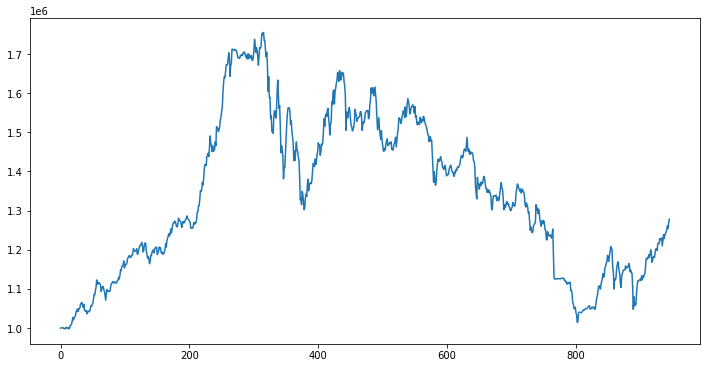

In [ ]:
ensemble_account_value.account_value.plot(figsize=(12,6))

In [ ]:
ensemble_account_value.to_csv("/content/drive/MyDrive/SOURCE/results/account_value(ensemble_30stocks).csv")
ensemble_account_value

,account_value,Date,daily_return,datadate
0,1.000000e+06,2016-12-29,NaN,2016-12-29
1,1.000091e+06,2016-12-30,0.000091,2016-12-30
2,1.000557e+06,2017-01-03,0.000465,2017-01-03
3,1.000956e+06,2017-01-04,0.000399,2017-01-04
4,1.000762e+06,2017-01-05,-0.000194,2017-01-05
...,...,...,...,...
941,1.251643e+06,2020-10-08,0.004911,2020-10-08
942,1.261371e+06,2020-10-09,0.007772,2020-10-09
943,1.254598e+06,2020-10-12,-0.005370,2020-10-12
944,1.270245e+06,2020-10-13,0.012472,2020-10-13


In [ ]:
ensemble_returns = get_daily_return(ensemble_account_value)

In [ ]:
ensemble_strat = backtest_stat(ensemble_account_value[0:946])

Annual return          0.067559
Cumulative returns     0.278150
Annual volatility      0.171879
Sharpe ratio           0.467141
Calmar ratio           0.160075
Stability              0.006082
Max drawdown          -0.422043
Omega ratio            1.088754
Sortino ratio          0.628516
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.969526
Daily value at risk   -0.021336
dtype: float64


##Backtest Plot

Start date,2016-12-29
End date,2020-10-14
Total months,45
,Backtest
Annual return,6.756%
Cumulative returns,27.815%
Annual volatility,17.188%
Sharpe ratio,0.47
Calmar ratio,0.16
Stability,0.01
Max drawdown,-42.204%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,42.20,2018-04-10,2020-03-23,NaT,NaN
1,4.58,2017-03-27,2017-04-17,2017-05-17,38
2,4.49,2017-07-06,2017-07-24,2017-08-30,40
3,3.79,2018-03-21,2018-03-29,2018-04-05,12
4,3.53,2018-01-15,2018-01-17,2018-01-22,6


Stress Events,mean,min,max
New Normal,0.03%,-5.67%,4.15%


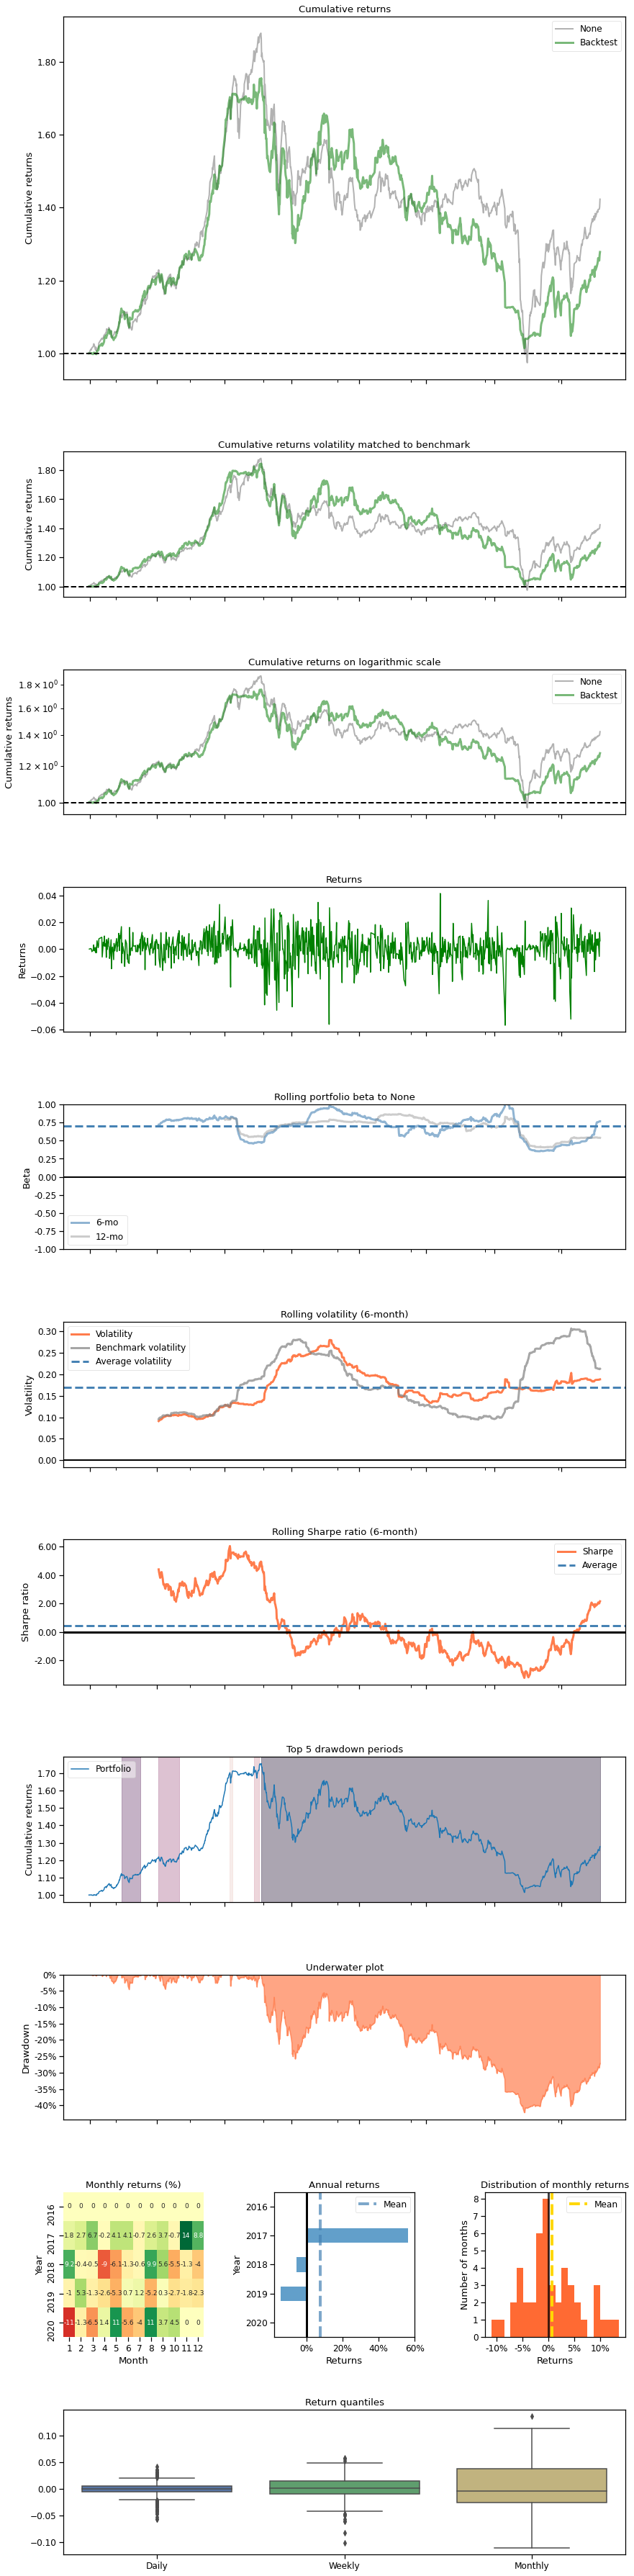

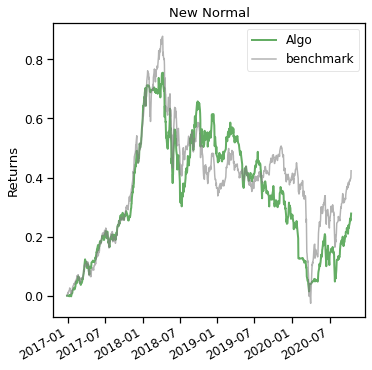

In [ ]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = ensemble_returns,
                                   benchmark_rets=baseline_returns, set_context=False)

#Performance

In [ ]:
en = pd.read_csv("/content/drive/MyDrive/SOURCE/results/account_value(ensemble_30stocks).csv", index_col=0)
en = en.dropna()
en.set_index('Date',inplace=True)
en

,account_value,daily_return,datadate
Date,,,
2016-12-30,9.997920e+05,-0.000208,2016-12-30
2017-01-03,1.000899e+06,0.001107,2017-01-03
2017-01-04,1.000873e+06,-0.000026,2017-01-04
2017-01-05,1.000727e+06,-0.000145,2017-01-05
2017-01-06,1.000668e+06,-0.000059,2017-01-06
...,...,...,...
2020-10-08,1.482015e+06,0.001523,2020-10-08
2020-10-09,1.494020e+06,0.008101,2020-10-09
2020-10-12,1.519413e+06,0.016997,2020-10-12


In [ ]:
a2c = pd.read_csv("/content/drive/MyDrive/SOURCE/results/account_value(a2c_30stocks).csv", index_col=0)
a2c=a2c.dropna()
a2c.set_index("Date",inplace=True)
#a2c.rename(columns={'a2c_dailyReturn':'daily_eturn'},inplace=True)
a2c

,account_value,daily_return,datadate
Date,,,
2016-12-30,9.999788e+05,-2.123109e-05,2016-12-30
2017-01-03,1.000306e+06,3.272590e-04,2017-01-03
2017-01-04,1.000605e+06,2.990746e-04,2017-01-04
2017-01-05,1.000605e+06,-9.554218e-08,2017-01-05
2017-01-06,1.000494e+06,-1.113795e-04,2017-01-06
...,...,...,...
2020-10-08,1.376508e+06,2.775748e-04,2020-10-08
2020-10-09,1.379199e+06,1.954899e-03,2020-10-09
2020-10-12,1.381192e+06,1.444628e-03,2020-10-12


In [ ]:
ppo = pd.read_csv("/content/drive/MyDrive/SOURCE/results/account_value(ppo_30stocks).csv", index_col=0)
ppo=ppo.dropna()
ppo.set_index("Date",inplace=True)
ppo

,account_value,daily_return,datadate
Date,,,
2016-12-30,1.000119e+06,0.000119,2016-12-30
2017-01-03,1.000682e+06,0.000563,2017-01-03
2017-01-04,1.001417e+06,0.000735,2017-01-04
2017-01-05,1.001468e+06,0.000050,2017-01-05
2017-01-06,1.000629e+06,-0.000837,2017-01-06
...,...,...,...
2020-10-08,1.312399e+06,0.004259,2020-10-08
2020-10-09,1.325128e+06,0.009699,2020-10-09
2020-10-12,1.332413e+06,0.005498,2020-10-12


In [ ]:
sac = pd.read_csv("/content/drive/MyDrive/SOURCE/results/account_value(sac_30stocks).csv", index_col=0)
sac=sac.dropna()
sac.set_index("Date",inplace=True)
sac

,account_value,daily_return,datadate
Date,,,
2016-12-30,1.000246e+06,0.000246,2016-12-30
2017-01-03,1.000975e+06,0.000729,2017-01-03
2017-01-04,1.001531e+06,0.000556,2017-01-04
2017-01-05,1.001372e+06,-0.000159,2017-01-05
2017-01-06,9.995102e+05,-0.001860,2017-01-06
...,...,...,...
2020-10-08,1.446375e+06,0.006229,2020-10-08
2020-10-09,1.446725e+06,0.000242,2020-10-09
2020-10-12,1.440678e+06,-0.004180,2020-10-12


In [ ]:
test_vn30['Date'] = pd.to_datetime(test_vn30['Date'])
test_vn30['datadate'] = sac['Date']
test_vn30.set_index('datadate', inplace=True)
test_vn30 = test_vn30.dropna()
test_vn30

,Symbol,Date,open,high,low,close,volume,daily_return_VN30
datadate,,,,,,,,
NaN,^VN30,2016-12-29,627.82,627.94,626.30,626.95,45339320,NaN
2016-12-30,^VN30,2016-12-30,625.80,628.21,625.18,628.21,46755430,0.002010
2017-01-03,^VN30,2017-01-03,627.65,634.18,627.58,633.89,42886270,0.009042
2017-01-04,^VN30,2017-01-04,632.80,635.39,630.46,632.70,52288190,-0.001877
2017-01-05,^VN30,2017-01-05,633.61,635.33,632.46,634.83,50348862,0.003367
...,...,...,...,...,...,...,...,...
2020-10-08,^VN30,2020-10-08,870.85,872.94,864.83,869.82,148307202,-0.001183
2020-10-09,^VN30,2020-10-09,869.82,875.32,868.55,874.53,125756012,0.005415
2020-10-12,^VN30,2020-10-12,874.53,882.80,871.83,874.90,143885260,0.000423


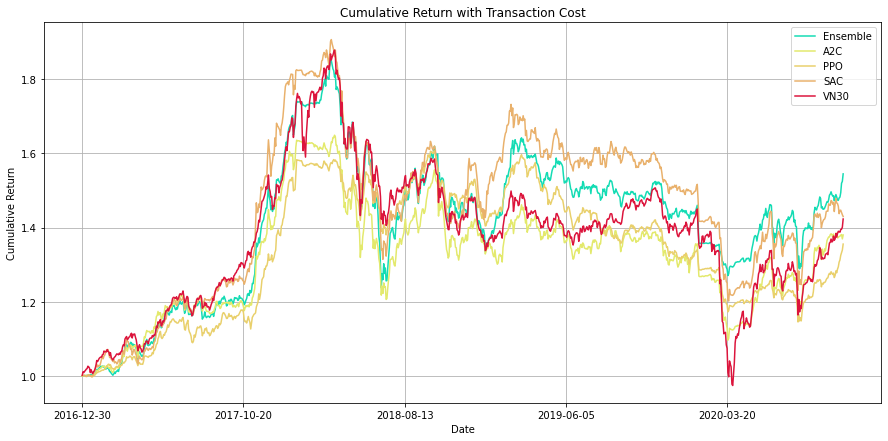

In [ ]:
fig,ax1 = plt.subplots(figsize=(15,7))

#(en['daily_return'] + 1).cumprod()
(en['daily_return'] + 1).cumprod().plot(color ='#14DCB4',label='Ensemble')
(a2c['daily_return'] +1).cumprod().plot(color = '#E3E96C',label='A2C')
(ppo['daily_return'] +1).cumprod().plot(color = '#E9D06C',label='PPO')
(sac['daily_return'] +1).cumprod().plot(color = '#E9B16C',label='SAC')
(test_vn30['daily_return_VN30'] +1).cumprod().plot(color ='#DC143C',label='VN30')


ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative Return")
ax1.set_title("Cumulative Return with Transaction Cost")
ax1.grid(True)
plt.legend()
#plt.savefig('/content/CumulativeReturn.png')
plt.show()

#Plot Turbulence

In [ ]:
en = pd.read_csv("/content/drive/MyDrive/SOURCE/results/account_value(ensemble_30stocks).csv", index_col=0)
en_tur = en[(en['Date']>='2020-01-01') & (en['Date']<='2020-06-01')]
en_tur.set_index('Date', inplace=True)
en_tur

,account_value,daily_return,datadate
Date,,,
2020-01-02,1.445636e+06,0.004287,2020-01-02
2020-01-03,1.437970e+06,-0.005303,2020-01-03
2020-01-06,1.434084e+06,-0.002702,2020-01-06
2020-01-07,1.434052e+06,-0.000023,2020-01-07
2020-01-08,1.424488e+06,-0.006669,2020-01-08
...,...,...,...
2020-05-26,1.419888e+06,0.014995,2020-05-26
2020-05-27,1.423515e+06,0.002554,2020-05-27
2020-05-28,1.435683e+06,0.008548,2020-05-28


In [ ]:
a2c = pd.read_csv("/content/drive/MyDrive/SOURCE/results/account_value(a2c_30stocks).csv", index_col=0)
a2c_tur = a2c[(a2c['Date']>='2020-01-01') & (a2c['Date']<='2020-06-01')]
a2c_tur.set_index("Date",inplace=True)
a2c_tur

,account_value,daily_return,datadate
Date,,,
2020-01-02,1.326071e+06,0.012338,2020-01-02
2020-01-03,1.319081e+06,-0.005271,2020-01-03
2020-01-06,1.300685e+06,-0.013946,2020-01-06
2020-01-07,1.306189e+06,0.004231,2020-01-07
2020-01-08,1.277984e+06,-0.021593,2020-01-08
...,...,...,...
2020-05-26,1.263563e+06,0.014756,2020-05-26
2020-05-27,1.267191e+06,0.002871,2020-05-27
2020-05-28,1.275501e+06,0.006558,2020-05-28


In [ ]:
ppo = pd.read_csv("/content/drive/MyDrive/SOURCE/results/account_value(ppo_30stocks).csv", index_col=0)
ppo_tur = ppo[(ppo['Date']>='2020-01-01') & (ppo['Date']<='2020-06-01')]
ppo_tur.set_index("Date",inplace=True)
ppo_tur

,account_value,daily_return,datadate
Date,,,
2020-01-02,1.331251e+06,0.006385,2020-01-02
2020-01-03,1.326505e+06,-0.003566,2020-01-03
2020-01-06,1.317328e+06,-0.006918,2020-01-06
2020-01-07,1.317605e+06,0.000210,2020-01-07
2020-01-08,1.301210e+06,-0.012443,2020-01-08
...,...,...,...
2020-05-26,1.240849e+06,0.005561,2020-05-26
2020-05-27,1.238240e+06,-0.002103,2020-05-27
2020-05-28,1.236670e+06,-0.001268,2020-05-28


In [ ]:
sac = pd.read_csv("/content/drive/MyDrive/SOURCE/results/account_value(sac_30stocks).csv", index_col=0)
sac_tur = sac[(sac['Date']>='2020-01-01') & (sac['Date']<='2020-06-01')]
sac_tur.set_index("Date",inplace=True)
sac_tur

,account_value,daily_return,datadate
Date,,,
2020-01-02,1.500106e+06,0.007451,2020-01-02
2020-01-03,1.503769e+06,0.002442,2020-01-03
2020-01-06,1.498965e+06,-0.003195,2020-01-06
2020-01-07,1.502054e+06,0.002061,2020-01-07
2020-01-08,1.498920e+06,-0.002087,2020-01-08
...,...,...,...
2020-05-26,1.387336e+06,0.018215,2020-05-26
2020-05-27,1.363262e+06,-0.017352,2020-05-27
2020-05-28,1.362559e+06,-0.000516,2020-05-28


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/DATASET/30stocks_done.csv", index_col=0)
data_turbulence = data[(data.Date>='2019-12-25') & (data.Date<='2020-06-01')]
insample_turbulence = data_turbulence.drop_duplicates(subset='Date')
insample_turbulence.set_index('Date', inplace=True)
insample_turbulence

,Symbol,adjust,close,high,low,open,volume,macd,rsi,cci,adx,sma,boll_ub,boll_lb,turbulence
Date,,,,,,,,,,,,,,,
2019-12-25,BMP,39.43,46.65,46.80,46.50,46.80,12440,1.179281,56.875245,-9.785933,10.723029,54.33,56.557512,51.032488,22.919785
2019-12-26,BMP,39.68,46.95,47.30,46.50,46.60,15880,1.055246,54.053576,-35.535977,10.723029,54.30,55.976852,51.993148,12.501138
2019-12-27,BMP,39.01,46.15,46.90,46.00,46.90,32460,0.985928,56.383890,-10.294118,10.723029,54.28,55.722974,52.497026,18.400846
2019-12-30,BMP,38.50,45.55,47.95,45.50,46.15,68450,0.880497,53.463729,-77.672530,10.723029,54.03,55.720494,52.449506,31.524505
2019-12-31,BMP,38.20,45.20,46.10,44.95,45.60,90280,0.724042,49.083546,-156.690998,4.506548,53.88,55.657228,52.282772,14.464654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-26,BMP,42.91,48.60,48.80,46.80,47.00,274890,1.406837,70.645279,139.066892,52.819479,59.64,62.753904,52.266096,33.146719
2020-05-27,BMP,42.69,48.35,48.75,48.35,48.60,129930,1.526024,71.848909,142.977756,59.378139,60.03,63.222234,52.647766,61.689761
2020-05-28,BMP,42.21,47.80,48.50,47.50,48.00,81520,1.578083,69.545711,109.897611,59.378139,60.27,63.471883,53.228117,22.562664


In [ ]:
test_vn30 = test_vn30[(test_vn30['Date']>='2020-01-01') & (test_vn30['Date']<='2020-06-01')]
test_vn30['Date'] = pd.to_datetime(test_vn30['Date'])
test_vn30['datadate'] = sac['Date']
test_vn30.set_index('datadate', inplace=True)
test_vn30

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Symbol,Date,open,high,low,close,volume,daily_return_VN30
datadate,,,,,,,,
2020-01-02,^VN30,2020-01-02,879.06,886.88,877.01,886.88,96928880,0.008896
2020-01-03,^VN30,2020-01-03,888.36,890.37,883.28,883.28,44169390,-0.004059
2020-01-06,^VN30,2020-01-06,879.10,879.68,872.34,872.34,55225846,-0.012386
2020-01-07,^VN30,2020-01-07,872.34,877.05,870.59,876.70,62497863,0.004998
2020-01-08,^VN30,2020-01-08,870.87,870.89,861.70,865.18,122997524,-0.013140
...,...,...,...,...,...,...,...,...
2020-05-26,^VN30,2020-05-26,809.64,815.85,807.84,815.01,106561220,0.009613
2020-05-27,^VN30,2020-05-27,818.94,821.35,801.36,801.36,130066290,-0.016748
2020-05-28,^VN30,2020-05-28,804.20,810.31,800.16,804.06,130053247,0.003369


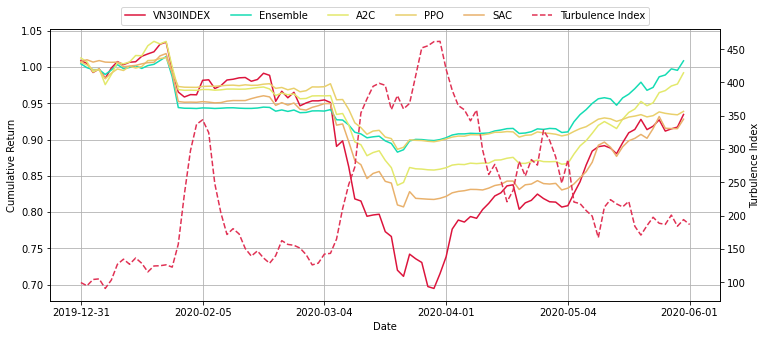

In [ ]:
fig,ax1 = plt.subplots(figsize=(12,5))
ax2 = ax1.twinx()

ax2.set_ylabel('Turbulence Index')
ax2.grid(True)

ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative Return")
#ax1.set_title("Cumulative Return with Transaction Cost")

(test_vn30['daily_return_VN30'] +1).cumprod().plot(ax =  ax1, color = '#DC143C',label='VN30')
(en_tur['daily_return'] + 1).cumprod().plot(ax= ax1 ,color ='#14DCB4',label='Ensemble')
(a2c_tur['daily_return'] +1).cumprod().plot(ax = ax1, color = '#E3E96C',label='A2C')
(ppo_tur['daily_return'] +1).cumprod().plot(ax = ax1, color = '#E9D06C',label='PPO')
(sac_tur['daily_return'] +1).cumprod().plot(ax =  ax1, color = '#E9B16C',label='SAC')
(insample_turbulence['turbulence']).rolling(5).sum().dropna().plot(ax = ax2, color = '#E03154', ls='--', label='Turbulence Index')

ax1.legend([ax1.get_lines()[0], ax1.get_lines()[1], ax1.get_lines()[2], ax1.get_lines()[3], ax1.get_lines()[4], ax2.get_lines()[0]], \
           ['VN30INDEX','Ensemble','A2C','PPO','SAC','Turbulence Index'], loc='upper center', bbox_to_anchor = (0.5, 1.10), \
           ncol = 6, fancybox=True)

ax1.grid(True)
#ax2.grid(True)
plt.savefig('/content/turbulence.png')

plt.show()


# Statistic Backtest

In [ ]:
en = pd.read_csv("/content/drive/MyDrive/SOURCE/results/account_value(ensemble_30stocks).csv", index_col=0)
e = backtest_stat(en)
e

Annual return          0.122806
Cumulative returns     0.544695
Annual volatility      0.169881
Sharpe ratio           0.768018
Calmar ratio           0.368539
Stability              0.209180
Max drawdown          -0.333224
Omega ratio            1.156207
Sortino ratio          1.053088
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.021329
Daily value at risk   -0.020885
dtype: float64


Annual return          0.122806
Cumulative returns     0.544695
Annual volatility      0.169881
Sharpe ratio           0.768018
Calmar ratio           0.368539
Stability              0.209180
Max drawdown          -0.333224
Omega ratio            1.156207
Sortino ratio          1.053088
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.021329
Daily value at risk   -0.020885
dtype: float64

In [ ]:
a2c = pd.read_csv("/content/drive/MyDrive/SOURCE/results/account_value(a2c_30stocks).csv", index_col=0)
a2 = backtest_stat(a2c)
a2

Annual return          0.089570
Cumulative returns     0.379922
Annual volatility      0.159418
Sharpe ratio           0.618648
Calmar ratio           0.267290
Stability              0.060588
Max drawdown          -0.335105
Omega ratio            1.119342
Sortino ratio          0.856016
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.923954
Daily value at risk   -0.019693
dtype: float64


Annual return          0.089570
Cumulative returns     0.379922
Annual volatility      0.159418
Sharpe ratio           0.618648
Calmar ratio           0.267290
Stability              0.060588
Max drawdown          -0.335105
Omega ratio            1.119342
Sortino ratio          0.856016
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.923954
Daily value at risk   -0.019693
dtype: float64

In [ ]:
ppo = pd.read_csv("/content/drive/MyDrive/SOURCE/results/account_value(ppo_30stocks).csv", index_col=0)
pp = backtest_stat(ppo)
pp

Annual return          0.084381
Cumulative returns     0.355413
Annual volatility      0.113877
Sharpe ratio           0.769213
Calmar ratio           0.293907
Stability              0.090175
Max drawdown          -0.287101
Omega ratio            1.145893
Sortino ratio          1.077981
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.954227
Daily value at risk   -0.014000
dtype: float64


Annual return          0.084381
Cumulative returns     0.355413
Annual volatility      0.113877
Sharpe ratio           0.769213
Calmar ratio           0.293907
Stability              0.090175
Max drawdown          -0.287101
Omega ratio            1.145893
Sortino ratio          1.077981
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.954227
Daily value at risk   -0.014000
dtype: float64

In [ ]:
sac = pd.read_csv("/content/drive/MyDrive/SOURCE/results/account_value(sac_30stocks).csv", index_col=0)
sa = backtest_stat(sac)
sa

Annual return          0.099902
Cumulative returns     0.429691
Annual volatility      0.176462
Sharpe ratio           0.628623
Calmar ratio           0.270258
Stability              0.133295
Max drawdown          -0.369655
Omega ratio            1.121937
Sortino ratio          0.885178
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.001124
Daily value at risk   -0.021792
dtype: float64


Annual return          0.099902
Cumulative returns     0.429691
Annual volatility      0.176462
Sharpe ratio           0.628623
Calmar ratio           0.270258
Stability              0.133295
Max drawdown          -0.369655
Omega ratio            1.121937
Sortino ratio          0.885178
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.001124
Daily value at risk   -0.021792
dtype: float64